TODO

* READ API DOCS:


1.   Anthropic https://docs.anthropic.com/en/docs/build-with-claude/vision
2.   Google https://docs.anthropic.com/en/docs/build-with-claude/vision
3.   Replicate https://docs.anthropic.com/en/docs/build-with-claude/vision

* IDEAS TO IMPLEMENT:

0.   Engineer the geoguessr player prompt
1.   Set output format for all models
2.   Returning directions to look at + querying streetview API
3.   Returning bounding box to zoom in, option to zoom out and look at another thing
4.   Future work: Videos, audio
5. Fix code to handle errors without crashing the block





In [ ]:
#@title requirements and imports
!pip install replicate openai anthropic --quiet
!pip install -q -U google-generativeai
import math
import csv
import os
import base64
import requests
import json
import re
import anthropic
import pandas as pd
import openai
import replicate
import anthropic
import google.generativeai as genai
from IPython.display import Markdown
import PIL.Image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 951.5/951.5 kB 15.6 MB/s eta 0:00:00


In [ ]:
#@title Setting keys
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['ANTHROPIC_API_KEY'] = userdata.get('ANTHROPIC_API_KEY')
os.environ['REPLICATE_API_TOKEN'] = userdata.get('REPLICATE_API_KEY')
os.environ['GEMINI_API_KEY'] = userdata.get('GEMINI_API_KEY')
os.environ['GOOGLE_MAPS_API_KEY'] = userdata.get('google_maps_api')

In [ ]:
#@title Cloning dataset
#!gdown --id '1AY8SvhaFkfLNcpr_xITB7NATnTGmi7cC' --folder
!gdown --id '1FodVI-dir7zIpGRVpjnRBgvyTILAOFCX' --folder
#!unzip dataset_v2/imgs_v2.zip -d dataset_v2
!unzip dataset_final_v1/imgs_final_v1.zip -d dataset_final_v1

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Retrieving folder contents
Processing file 1B_u-oW9YGNCsOI6Uxi9XcCmaTlWLSxf- 20percent__of_benchmark.csv
Processing file 1UdLV7U9eRFkgQcavl03GA6x1jkZpLsCZ img_coordinates_final_v1_with_country.csv
Processing file 1AAAbMBNCoEuq7KceH7L0At1G6VyQcFbP img_coordinates_final_v1.csv
Processing file 1r_PEgSr6YNBfZ3DQoSyg0o92XIkwsHFz imgs_final_v1.zip
Processing file 1GTAP0QlsRJJXhRb60rsBgS1dsU5MomYD sampled_cities_v1.csv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1B_u-oW9YGNCsOI6Uxi9XcCmaTlWLSxf-
To: /content/dataset_final_v1/20percent__of_benchmark.csv
100% 26.2k/26.2k [00:00<00:00, 45.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UdLV7U9eRFkgQcavl03G

In [ ]:
#@title Get image names
import pandas as pd
df = pd.read_csv('/content/dataset_final_v1/img_coordinates_final_v1_with_country.csv')
image_names = df['filename'].tolist()
df.head()


,filename,city_name,lat,lng,heading,country
0,imgs_final_v1/0.jpg,Geelong,-38.148907,144.348668,343,Australia
1,imgs_final_v1/1.jpg,Townsville,-19.249273,146.817089,51,Australia
2,imgs_final_v1/2.jpg,Tauranga,-37.683999,176.167290,185,New Zealand
3,imgs_final_v1/3.jpg,Cairns,-16.919275,145.778679,341,Australia
4,imgs_final_v1/4.jpg,Darwin,-12.437700,130.840366,73,Australia


In [ ]:
import os

image_dir = '/content/dataset_final_v1/imgs_final_v1'
num_pictures = len([name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))])

print(f"Number of pictures in the directory: {num_pictures}")


Number of pictures in the directory: 1602


dataset_final_v1/imgs_final_v1/0.jpg


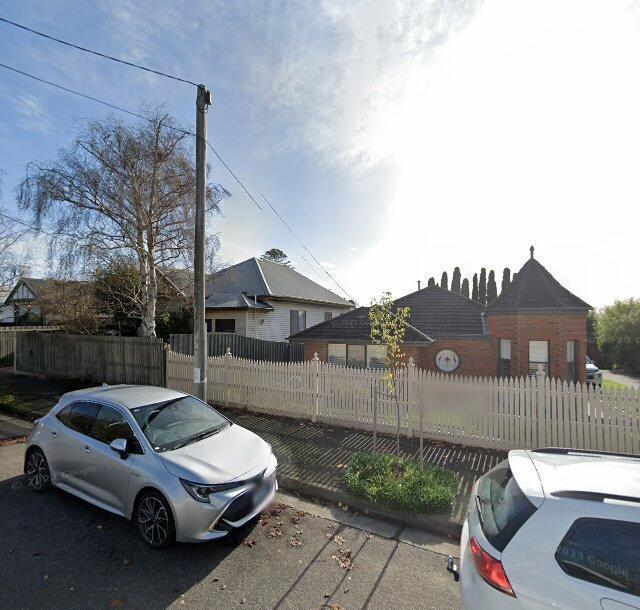

dataset_final_v1/imgs_final_v1/1.jpg


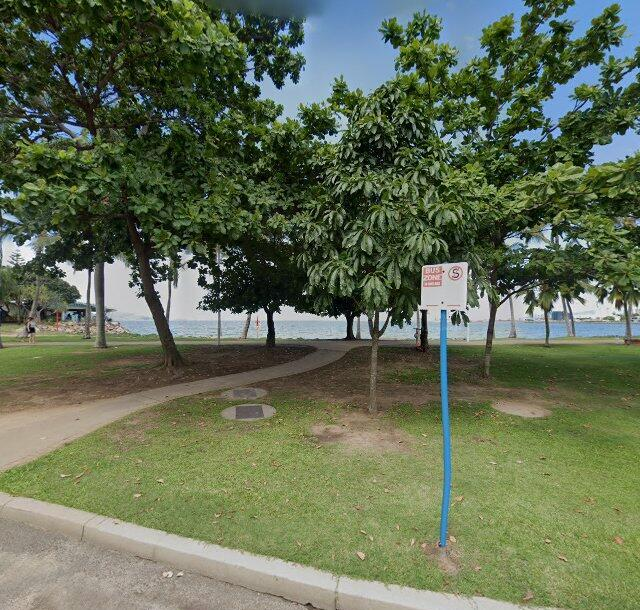

dataset_final_v1/imgs_final_v1/2.jpg


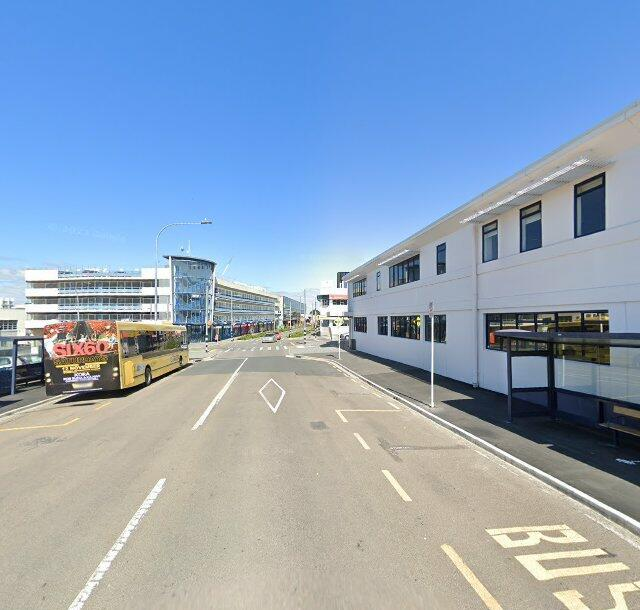

dataset_final_v1/imgs_final_v1/3.jpg


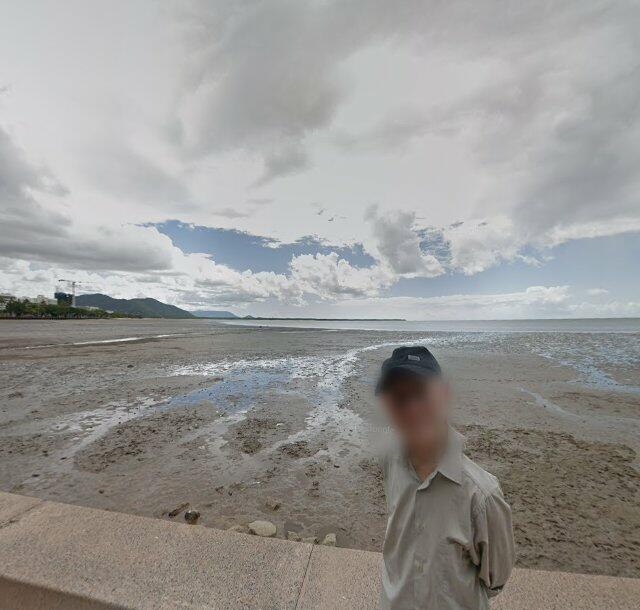

dataset_final_v1/imgs_final_v1/4.jpg


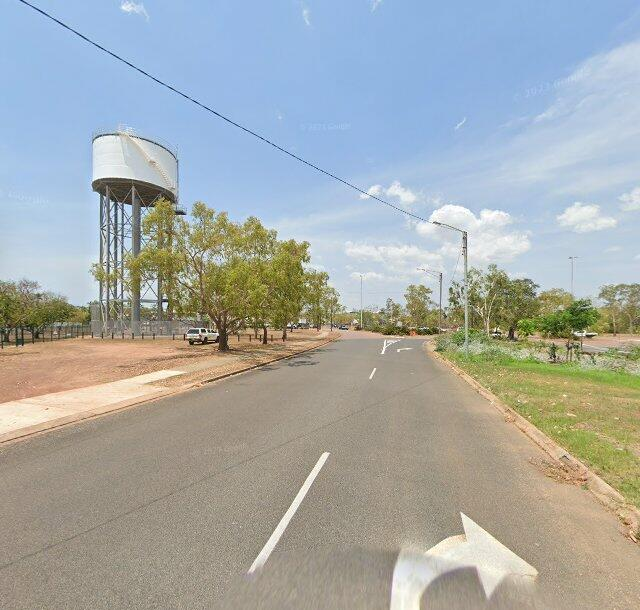

In [ ]:
#@title Sample images
from IPython.display import Image, display

dir = 'dataset_final_v1/'
for i in range(5):
  name = dir + image_names[i]
  print(name)
  display(Image(filename=name))


In [ ]:
#@title Functions


import math

def calculate_distance(lat1, lon1, lat2, lon2):
    """
    Calculates the distance between two sets of coordinates using the Haversine formula.

    Args:
        lat1 (float): Latitude of the first set of coordinates.
        lon1 (float): Longitude of the first set of coordinates.
        lat2 (float): Latitude of the second set of coordinates.
        lon2 (float): Longitude of the second set of coordinates.

    Returns:
        float: The distance between the two sets of coordinates in kilometers.
    """
    R = 6371  # Earth's radius in kilometers

    # Convert degrees to radians
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    # Calculate the Haversine formula
    a = math.sin(delta_phi / 2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c

    return distance



def encode_image(image_path):
    with open(image_path, "rb") as image_file:
      return base64.b64encode(image_file.read()).decode('utf-8')

def fix_json_string(string_test):
    try:

        json.loads(string_test)

        return string_test
    except json.JSONDecodeError:

        pattern = r'("(?:lat|long|city|country|[^"]+)":\s*)([^",\}\]]+)(?=[,\}\]])'

        def add_quotes(match):
            key = match.group(1)
            value = match.group(2).strip()

            if re.match(r'^-?\d+(\.\d+)?$', value):
                return f'{key}{value}'
            else:
                return f'{key}"{value}"'

        # Apply the regex substitution
        fixed_string = re.sub(pattern, add_quotes, string_test)

        try:
            # Try to parse the fixed string
            json.loads(fixed_string)
            # If successful, return the fixed string
            return fixed_string
        except json.JSONDecodeError:
            # If still invalid, return the original string
            return string_test

def response_openai(api_key, prompt, filename):
    openai_client = openai.OpenAI()
    base64_image = encode_image(filename)

    headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {api_key}"
        }

    payload = {
        "model": "gpt-4o-mini",
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": f"{prompt}"
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}"
                        }
                    }
                ],

            }
        ],
        "max_tokens": 1024,
        "temperature": 0,
    }
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    return response.json()

def response_claude(api_key, prompt, filename):
    client = anthropic.Anthropic()

    image1_media_type = "image/jpeg"

    base64_image = encode_image(filename)

    message = client.messages.create(
        model="claude-3-opus-latest",
        max_tokens=1024,
        temperature=0,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "image",
                        "source": {
                            "type": "base64",
                            "media_type": image1_media_type,
                            "data": base64_image,
                        },
                    },
                    {
                        "type": "text",
                        "text": f"{prompt}"
                    }
                ],
            }
        ],
    )
    # get content with message.content[0].text
    return message

def response_replicate(api_key, prompt, filename):
    client = replicate.Client(api_token=api_key)

    with open(filename, 'rb') as file:
        response = requests.post('https://file.io', files={'file': file})
        image_url = response.json()['link']

    output = replicate.run(
        "lucataco/fuyu-8b:42f23bc876570a46f5a90737086fbc4c3f79dd11753a28eaa39544dd391815e9",
        input={
            "image": image_url,
            "top_p": 1,
            "prompt": prompt,
            "max_tokens": 1024,
            "temperature": 0.2
        }
    )

    text = ""
    for item in output:
        text += item

    return text

def response_gemini(api_key, prompt, filename):
    genai.configure(api_key=api_key)
    model = genai.GenerativeModel('gemini-1.5-flash')

    # Open the image file using PIL
    image = PIL.Image.open(filename)

    # Generate content using the opened image file
    response = model.generate_content([prompt, image])

    return response.text



In [ ]:
prompt = """
You are a top-ranked, professional, competitive world-class GeoGuessr player, renowned for your ability to accurately pinpoint the location of images based solely on the visual clues they provide. You have a keen eye for detail and an extensive knowledge of geography that allows you to make insightful deductions.

You have been presented with a new image, and your task is to use your exceptional skills to determine the precise coordinates of the location depicted. Carefully examine the image, taking note of any distinctive features, landmarks, vegetation, or other elements that could serve as clues. Piece together a chain of thought, step by step, to infer the most likely location.

Once you have gathered sufficient evidence, provide your best guess for the coordinates in the following JSON format:

{"lat": latitude, "long": longitude, "city": city, "country": country}

If you cannot narrow it down, then provide your best guess.

Be as specific as possible, narrowing down the location to a particular region, city, or even a specific landmark or intersection. Your goal is to demonstrate your expertise as a GeoGuessr master by providing a highly accurate and well-reasoned response.
"""

In [ ]:
responses = []
lats = []
longs = []
cities = []
countries = []

In [ ]:
#@title Evaluate models
model_type = "claude" #@param ["claude", "openai", "replicate", "gemini"]

import time

for i in range(len(image_names)):
  filename = f'/content/dataset_final_v1/{image_names[i]}'
  print(f"Processing image: {filename}")

  percent_complete = ((i + 1)  / (len(image_names) )) * 100
  bar_length = 20
  filled_length = int(bar_length * (i + 1) // len(image_names))
  bar = '=' * filled_length + '-' * (bar_length - filled_length)
  print(f'\rProcessing image {i+1}/{len(image_names)} [{bar}] {percent_complete:.1f}%', end='')
  print("\n\n")

  if model_type == "claude":
    time.sleep(0.5)
    response = response_claude(os.environ['ANTHROPIC_API_KEY'], prompt, filename)
    text_response = response.content[0].text
    print(text_response)
  elif model_type == "openai":

    response = response_openai(os.environ['OPENAI_API_KEY'], prompt, filename)
    text_response = response['choices'][0]['message']['content']
    print(text_response)
  elif model_type == "replicate":
    text_response = response_replicate_molmo7b(os.environ['REPLICATE_API_TOKEN'], prompt, filename)
    print(text_response)
  elif model_type == "gemini":
    time.sleep(10) #horrifying latency
    text_response = response_gemini(os.environ['GEMINI_API_KEY'], prompt, filename)
    print(text_response)
  else:
    print("Invalid model type selected.")

  start = text_response.find('{')
  end = text_response.find('}') + 1


  json_str = text_response[start:end]

  json_str = fix_json_string(json_str)

  if json_str:
    print(json_str)
    data = json.loads(json_str)

    responses.append(text_response)
    lats.append(data['lat'])
    longs.append(data['long'])
    cities.append(data['city'])
    countries.append(data['country'])

  else:
    print("No JSON object found in the string.")
    responses.append(text_response)
    lats.append(None)
    longs.append(None)
    cities.append(None)
    countries.append(None)

Streaming output truncated to the last 5000 lines.

Of course, without more specific landmarks or other definitive visual cues, I cannot be 100% certain of the exact location. But based on my analysis of the available evidence, I believe this is the most likely answer for where this image was captured.
{"lat": 45.5236, "long": -122.6750, "city": "Portland", "country": "United States"}
Processing image: /content/dataset_final_v1/imgs_final_v1/1275.jpg
Processing image 1276/1602 [===============-----] 79.7%


Based on the lush, tropical vegetation and the presence of a paved path, this image appears to depict a location in a tropical or subtropical region. The dense foliage and the presence of what looks like a small stream or creek suggest a humid, forested environment.

Considering these visual cues, my best guess for the location of this image is:

{"lat": 10.4718, "long": -84.6687, "city": La Fortuna, "country": Costa Rica}

The dense, verdant vegetation and the overall landscape are

In [ ]:
#@title add labels and calculate distances

label_lats = df['lat']
label_longs = df['lng']
label_countries = df['country']
label_cities = df['city_name']

results_df = pd.DataFrame({
    'image_name': image_names,
    'model_response': responses,
    'label_city': label_cities,
    'label_country': label_countries,
    'predicted_city': cities,
    'predicted_country': countries,
    'label_lat': label_lats,
    'label_long': label_longs,
    'predicted_lat': lats,
    'predicted_long': longs,
})

distances = []
for i in range(len(lats)):
  if lats[i] is not None and longs[i] is not None:
    distance = calculate_distance(label_lats[i], label_longs[i], lats[i], longs[i])
  else:
    distance = None
  distances.append(distance)

results_df['distance'] = distances

In [ ]:
len(responses)

1602

In [ ]:
results_df.to_csv("results.csv", index = False)